# Geospatial ML Challenges: A prospectivity analysis example




In [5]:
# import basic libraries
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# set some default plotting parameters for nicer looking plots
mpl.rcParams.update({"axes.grid":True, "grid.color":"gray", "grid.linestyle":'--','figure.figsize':(10,10)})

In [6]:
# set path to data directory
data_dir = r'/mnt/c/working/transform_2022/data/'

# set paths to key data sets
point_fn = os.path.join(data_dir, 'sn_w_minoccs.gpkg')
raster_fns = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if '.tif' in x and 'xml' not in x]
point_fn, raster_fns

('/mnt/c/working/transform_2022/data/sn_w_minoccs.gpkg',
 ['/mnt/c/working/transform_2022/data/tasgrav_IR.tif',
  '/mnt/c/working/transform_2022/data/tasgrav_IR_1VD.tif',
  '/mnt/c/working/transform_2022/data/tasmag_TMI.tif',
  '/mnt/c/working/transform_2022/data/tasmag_TMI_1VD.tif',
  '/mnt/c/working/transform_2022/data/tasrad_K_pct.tif',
  '/mnt/c/working/transform_2022/data/tasrad_Th_ppm.tif',
  '/mnt/c/working/transform_2022/data/tasrad_U_ppm.tif'])

In [7]:
# import import geopandas
import geopandas as gpd

# read the mineral occurences
df = gpd.read_file(point_fn)
df.head(2)

GID  DEPOSIT_ID              NAME                 ALIAS  PARENT_ID  \
0   1987        1992     Great Pyramid           Brocks Adit        NaN   
1  14795        2002  North Ringarooma  North Ringarooma Bay        NaN   

               TYPE COMM_TYPE                                COMMODITYS  \
0  Mine or Prospect    Metals  Tin, Silver, Copper, Arsenic, Lead, Zinc   
1  Mine or Prospect    Metals                           Tin, Lead, Zinc   

                 DESCRIPT               LOCALITY  ...  \
0        shafts and adits           Pyramid Hill  ...   
1  a few surface trenches  5-6km NW of Scamander  ...   

                                           EXPL_TYPE OUTCROPS  WEATHERED  \
0  Drilling, Geochemical surveys, Geological mapp...     None       None   
1                   Geochemical surveys, Prospecting     None          Y   

   XTRCTBLTY  USES TESTS GENETIC DATA_MTLGA  \
0       None  None  None    None       None   
1       None  None  None    None       None   

                                                 REF  \
0  UR1928A_064_71, TR8_25_45, GSB53, 84_2218, 86_...   
1    GSB53, UR1941_005_11, 84_2218, 90_3120, 17_7703   

                         geometry  
0  POINT (599712.822 5413483.986)  
1  POINT (600762.824 5413543.986)  

[2 rows x 38 columns]

In [8]:
# import rasterio library for raster reading
import rasterio

# loop through geotiff files and read bands into an array
data, names = [], []
for fn in raster_fns:
  with rasterio.open(fn, 'r') as src:
    # read the coordinate transform
    transf = src.transform
    # create an extent tuple containing (xmin, xmax, ymin, ymax) for the rasters
    region = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    # read the data, derive a nodata mask and nullify nodata pixels
    d = src.read(1)
    nodata_mask = d == src.nodata
    d[nodata_mask] = np.nan
    # append data to data list and append file names to names list (remove .tif file extension)
    data.append(d)
    names.append(os.path.basename(fn).split('.')[0])

# combine 2D raster arrays into 3D stack, print some details
data = np.stack(data)
print ('3D (Nbands, Nycolumns, Nxcolumns) data cube shape: {}'.format(data.shape))
print ('Geophysical data sets in cube:\n', names)

3D (Nbands, Nycolumns, Nxcolumns) data cube shape: (7, 2633, 1876)
Geophysical data sets in cube:
 ['tasgrav_IR', 'tasgrav_IR_1VD', 'tasmag_TMI', 'tasmag_TMI_1VD', 'tasrad_K_pct', 'tasrad_Th_ppm', 'tasrad_U_ppm']


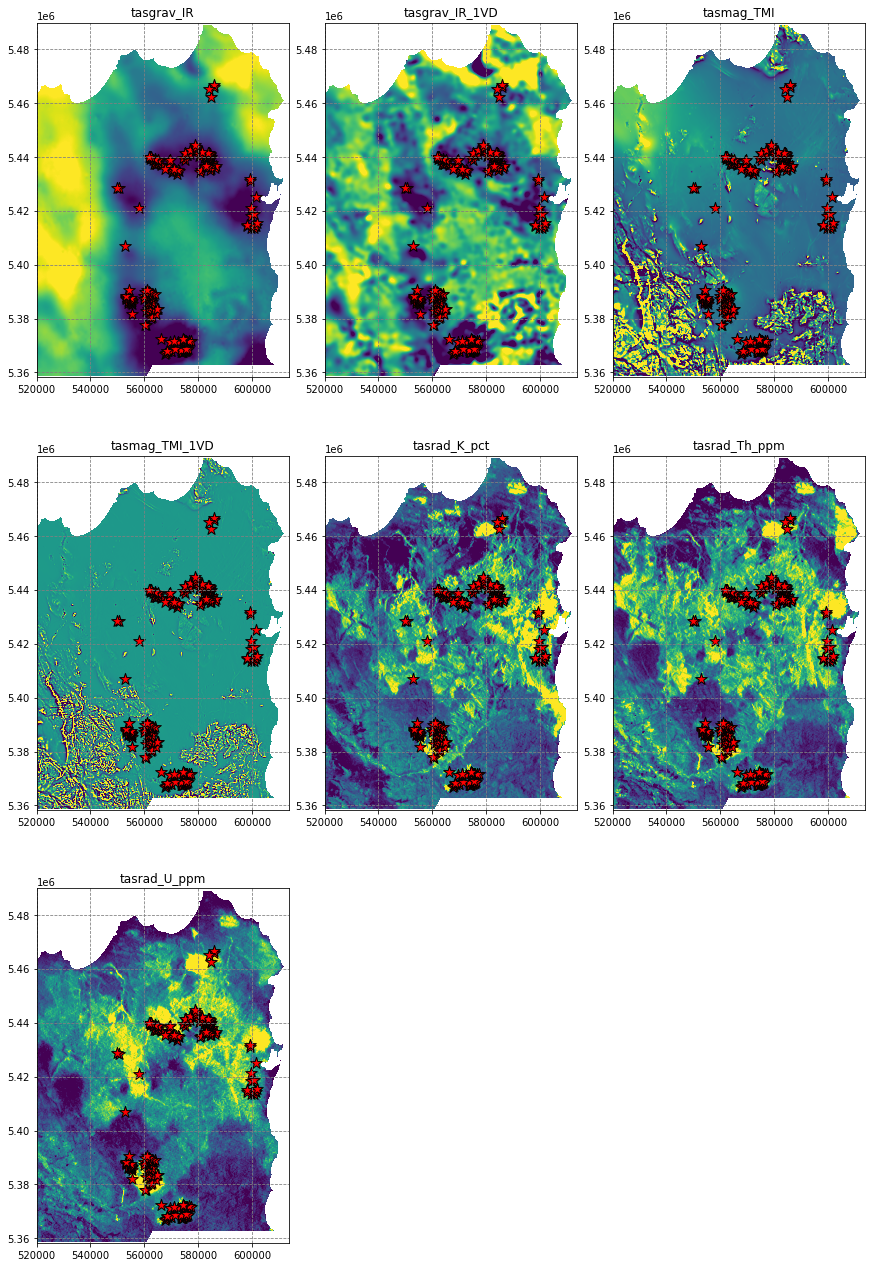

In [9]:
# plot the data sets
fig, axes = plt.subplots(3, 3, figsize=(12,18), constrained_layout=True)
for i, ax in enumerate(axes.flatten()):
  if i < data.shape[0]:
    ax.imshow(data[i], extent=region, vmin=np.nanpercentile(data[i], 5), vmax=np.nanpercentile(data[i], 95))
    df.plot(ax=ax, markersize=150, facecolor='r', color='k', marker='*', linewidth=1)
    ax.set(title=names[i])
  else:
    ax.axis('off')
plt.show()

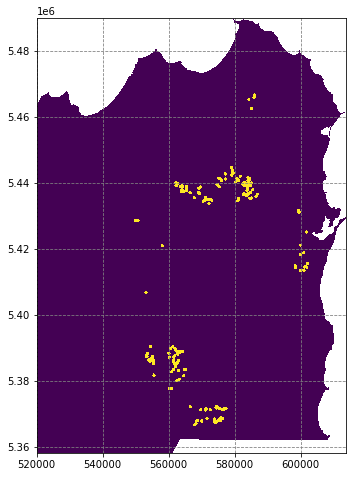

In [12]:
# import the rasterize module
from rasterio.features import rasterize

# rasterise the occurence points such that pixels within 500m are labelled '1', and all other are labelled '0'
labels = rasterize(shapes=((geom,1.) for geom in df.buffer(500).geometry), out_shape=data[0].shape, fill=0., transform=transf)

# apply the no data mask
labels[nodata_mask] = np.nan

# plot the predictions
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(labels, extent=region, interpolation='nearest')
plt.show()

X_pix data array shape is (4939508, 7), y_pix labels array shape is (4939508,)
X data array shape is (4002948, 7), y labels array shape is (4002948,)


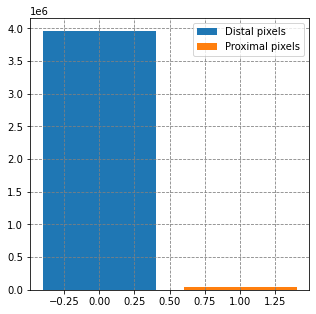

In [13]:
# reshape arrays to derive a X (Npixels, Nfeatures) array and y (Npixels) array
X_pix = data.reshape((data.shape[0], data.shape[1] * data.shape[2])).T
y_pix = labels.flatten()
print ('X_pix data array shape is {}, y_pix labels array shape is {}'.format(X_pix.shape, y_pix.shape))

# remove nodata pixels from both data sets
X = X_pix[~np.isnan(y_pix)]
y = y_pix[~np.isnan(y_pix)]
print ('X data array shape is {}, y labels array shape is {}'.format(X.shape, y.shape))

# summarise the data set
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(0, y[y==0].shape, label='Distal pixels')
ax.bar(1, y[y==1].shape, label='Proximal pixels')
ax.legend()
plt.show()

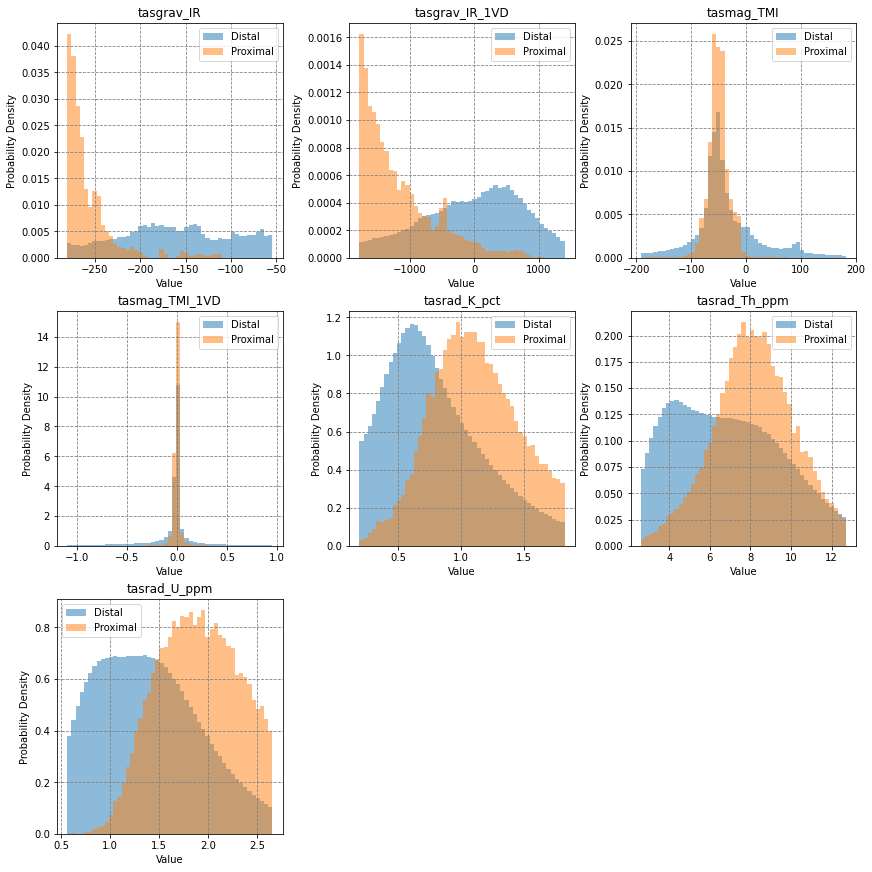

In [14]:
# visualise histograms
fig, axes = plt.subplots(3, 3, figsize=(12,12), constrained_layout=True)
for i, ax in enumerate(axes.flatten()):
  if i < data.shape[0]:
    bins = np.linspace(np.percentile(X[:,i], 5), np.percentile(X[:,i], 95), 50)
    for j, label in zip([0,1], ['Distal','Proximal']):
      ax.hist(X[y==j, i], bins=bins, density=True, alpha=0.5, label=label)
    ax.legend()
    ax.set(title=names[i], ylabel='Probability Density', xlabel='Value')
  else:
    ax.axis('off')
plt.show()

### Train Models

In [15]:
# import some sci-kit learn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# build a random training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# define model, fit it to the data
model1 = RandomForestClassifier(n_estimators=15, n_jobs=-1)
model1.fit(X_train, y_train)

RandomForestClassifier(n_estimators=15, n_jobs=-1)

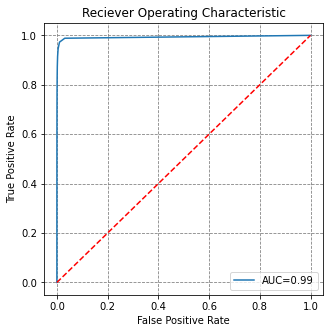

In [16]:
# import reciever operating characteristic curve and area under the curve metrics
from sklearn.metrics import roc_curve, auc

# evaluate the model on the test data set
y_preds = model1.predict(X_test)
y_proba = model1.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1])
roc_auc = auc(fpr, tpr)

# visualise this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label='AUC=%0.2f' % roc_auc)
ax.plot([0,1], [0,1], 'r--')
ax.set(title='Reciever Operating Characteristic', 
       ylabel='True Positive Rate', xlabel='False Positive Rate')
ax.legend()
plt.show()

/tmp/ipykernel_3073/758455179.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')


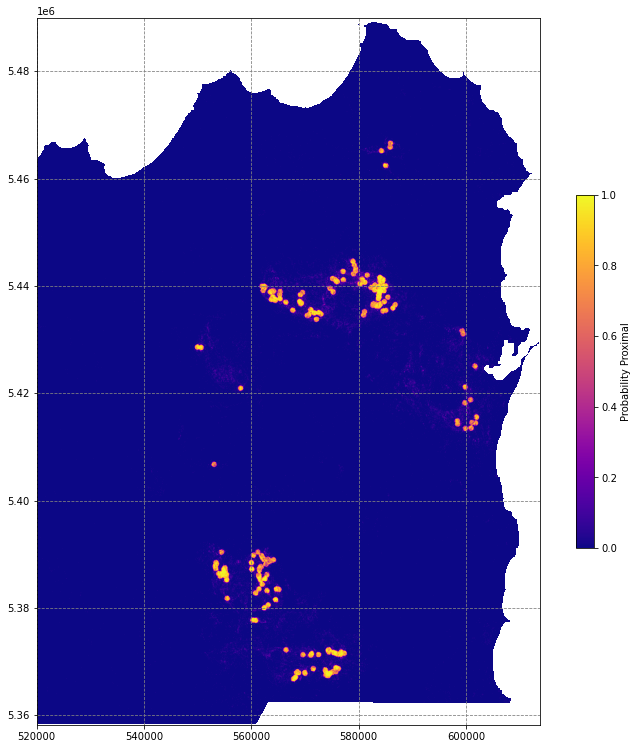

In [22]:
# define get probability map function
def get_proba_map(data_cube, nodata_mask, model):
    # reshape data cube to 2d and remove nans
    X = data_cube.reshape((data_cube.shape[0], data_cube.shape[1]*data_cube.shape[2])).T
    X = X[~nodata_mask.flatten()]
    # generate prediction probabilities for class 1
    predictions = model.predict_proba(X)[:,1]
    # create an output array based on flattened mask raster
    pred_ar = np.zeros(shape=nodata_mask.flatten().shape, dtype='float32')
    # insert predictions, reshape to spatial and nullify nodata area
    pred_ar[~nodata_mask.flatten()] = predictions
    pred_ar = pred_ar.reshape(nodata_mask.shape)
    pred_ar[nodata_mask] = np.nan
    return pred_ar

# use function to generate a prediction raster
pred_ar1 = get_proba_map(data, nodata_mask, model1)


# plot the predictions
fig, ax = plt.subplots(figsize=(13,13))
im = ax.imshow(pred_ar1, extent=region, cmap='plasma')
fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')
# df.plot(ax=ax, markersize=250, facecolor='w', color='k', marker='*', linewidth=1)
plt.show()

In [12]:
# import random undersampling module from imbalanced learn library
from imblearn.under_sampling import RandomUnderSampler 

# stratify the classes with a random undersampler
rus = RandomUnderSampler(random_state=42)
X_strat, y_strat = rus.fit_resample(X, y)
print ('Before random undersampling:\n\t{} class 0 samples vs. {} class 1 samples'.format(len(y_train[y_train==0]), len(y_train[y_train==1])))
print ('After random undersampling:\n\t{} class 0 samples vs. {} class 1 samples'.format(len(y_strat[y_strat==0]), len(y_strat[y_strat==1])))

# build a random training and testing split
X_train, X_test, y_train, y_test = train_test_split(X_strat, y_strat, test_size=0.33, random_state=42)

# define model, fit it to the stratified data data
model2 = RandomForestClassifier(n_estimators=15, n_jobs=-1)
model2.fit(X_train, y_train)

Before random undersampling:
	2653929 class 0 samples vs. 28046 class 1 samples
After random undersampling:
	41895 class 0 samples vs. 41895 class 1 samples


RandomForestClassifier(n_estimators=15, n_jobs=-1)

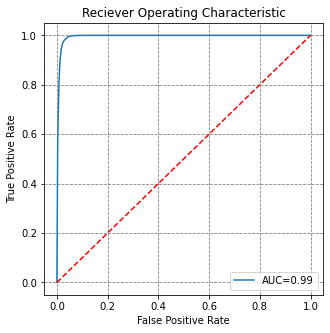

In [13]:
# evaluate the model on the test data set
y_preds = model2.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_preds[:,1])
roc_auc = auc(fpr, tpr)

# visualise this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label='AUC=%0.2f' % roc_auc)
ax.plot([0,1], [0,1], 'r--')
ax.set(title='Reciever Operating Characteristic', 
       ylabel='True Positive Rate', xlabel='False Positive Rate')
ax.legend()
plt.show()

/tmp/ipykernel_28321/1785768611.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')


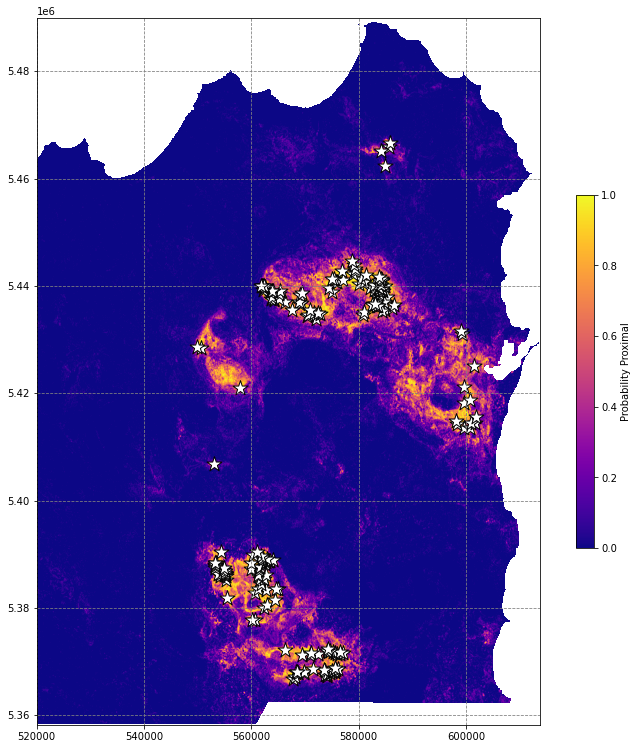

In [14]:
# get spatial results
pred_ar2 = np.zeros_like(data[0].flatten())
pred_ar2[~nodata_mask.flatten()] = model2.predict_proba(X)[:,1]
pred_ar2[nodata_mask.flatten()] = np.nan
pred_ar2 = pred_ar2.reshape(data[0].shape)

# plot the predictions
fig, ax = plt.subplots(figsize=(13,13))
im = ax.imshow(pred_ar2, extent=region, cmap='plasma')
fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')
df.plot(ax=ax, markersize=250, facecolor='w', color='k', marker='*', linewidth=1)
plt.show()

This is better, but the workflow suffers from a critical issue that makes us overestimate model purformance - spatial autocorrelation.

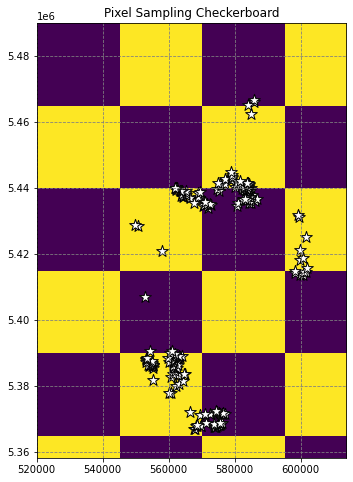

In [15]:
# define checkerboard function 
def make_checkerboard(boardsize, squaresize):
  '''
  props to stackoverflow user Blubberguy22, posted March 17, 2020 at 19:00
  https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy
  '''
  return np.fromfunction(lambda i, j: (i//squaresize[0])%2 != (j//squaresize[1])%2, boardsize).astype(int)

# make a checkerboard, plot it
checker = make_checkerboard(data[0].shape, (500,500))
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(checker, extent=region, interpolation='nearest')
df.plot(ax=ax, markersize=150, facecolor='w', color='k', marker='*', linewidth=1)
ax.set(title='Pixel Sampling Checkerboard')
plt.show()

Checker 0: X data array shape is (2009157, 7), y labels array shape is (2009157,)
Checker 1: X data array shape is (1993791, 7), y labels array shape is (1993791,)


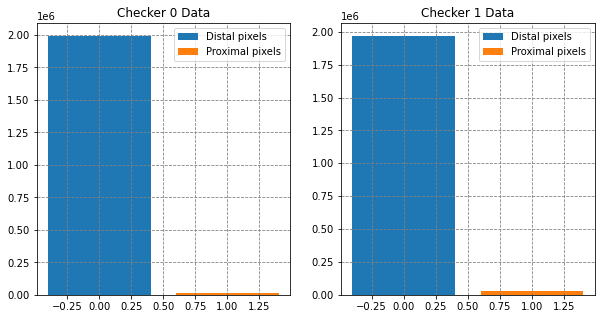

In [16]:
# split these data into two using the checkerboard
X_check0 = X_pix[checker.flatten()==0]
y_check0 = y_pix[checker.flatten()==0]

X_check1 = X_pix[checker.flatten()==1]
y_check1 = y_pix[checker.flatten()==1]

# remove nans
X_check0 = X_check0[~np.isnan(y_check0)]
y_check0 = y_check0[~np.isnan(y_check0)]

X_check1 = X_check1[~np.isnan(y_check1)]
y_check1 = y_check1[~np.isnan(y_check1)]

# print some details
print ('Checker 0: X data array shape is {}, y labels array shape is {}'.format(X_check0.shape, y_check0.shape))
print ('Checker 1: X data array shape is {}, y labels array shape is {}'.format(X_check1.shape, y_check1.shape))

# summarise the data set
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,5))
ax0.bar(0, y_check0[y_check0==0].shape, label='Distal pixels')
ax0.bar(1, y_check0[y_check0==1].shape, label='Proximal pixels')
ax1.bar(0, y_check1[y_check1==0].shape, label='Distal pixels')
ax1.bar(1, y_check1[y_check1==1].shape, label='Proximal pixels')
[ax.legend() for ax in [ax0, ax1]]
[ax.set(title=t) for ax, t in zip([ax0, ax1], ['Checker 0 Data', 'Checker 1 Data'])]
plt.show()

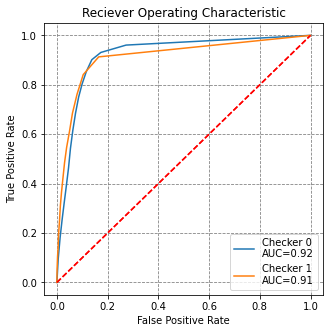

In [17]:
# stratify the checker data sets
X_check0, y_check0 = rus.fit_resample(X_check0, y_check0)
X_check1, y_check1 = rus.fit_resample(X_check1, y_check1)

# define models fit them to different checkerboard data selections
model3 = RandomForestClassifier(n_estimators=15, n_jobs=-1)
model3.fit(X_check0, y_check0)

model4 = RandomForestClassifier(n_estimators=15, n_jobs=-1)
model4.fit(X_check1, y_check1)

# evaluate the models on checker data unseen in training
roc_data = []
for model, X_check, y_check in zip([model3, model4], [X_check1, X_check0], [y_check1, y_check0]):
  y_pred = model.predict_proba(X_check)
  fpr, tpr, threshold = roc_curve(y_check, y_pred[:,1])
  roc_auc = auc(fpr, tpr)
  roc_data.append((fpr, tpr, roc_auc))

# visualise this
fig, ax = plt.subplots(figsize=(5,5))
for i, (fpr, tpr, roc_auc) in enumerate(roc_data):
  ax.plot(fpr, tpr, label='Checker {}\nAUC={}'.format(i, round(roc_auc,2)))
  ax.plot([0,1], [0,1], 'r--')
ax.set(title='Reciever Operating Characteristic', 
       ylabel='True Positive Rate', xlabel='False Positive Rate')
ax.legend()
plt.show()

/tmp/ipykernel_28321/267784532.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')
/tmp/ipykernel_28321/267784532.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')


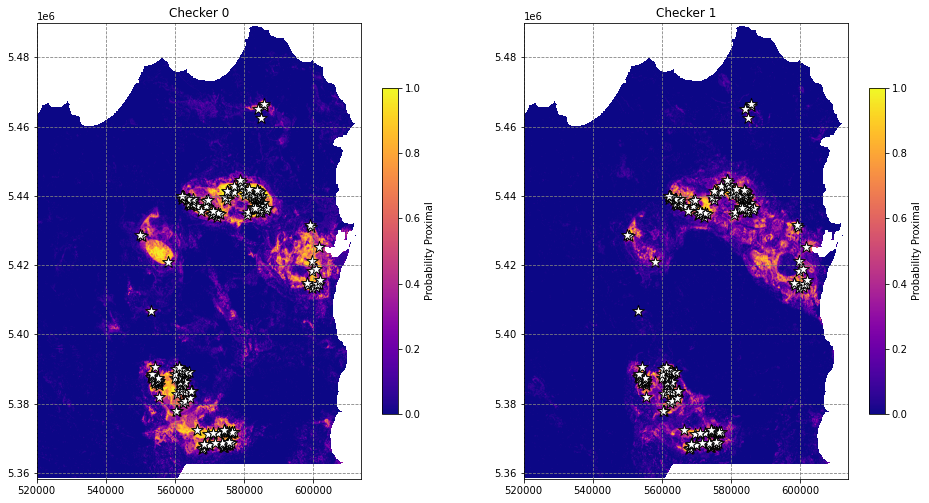

In [18]:
# get spatial results
pred_ars = []
for i, model in enumerate([model3, model4]):
  pred_ar = np.zeros_like(data[0].flatten())
  pred_ar[~nodata_mask.flatten()] = model.predict_proba(X)[:,1]
  pred_ar[nodata_mask.flatten()] = np.nan
  pred_ars.append(pred_ar.reshape(data[0].shape))

# plot the predictions
fig, axes = plt.subplots(1, 2, figsize=(16,12))
for i, (ax, t) in enumerate(zip(axes, ['Checker 0', 'Checker 1'])):
  im = ax.imshow(pred_ars[i], extent=region, cmap='plasma')
  fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')
  df.plot(ax=ax, markersize=150, facecolor='w', color='k', marker='*', linewidth=1)
  ax.set(title=t)
plt.show()

Mineral Field holdout

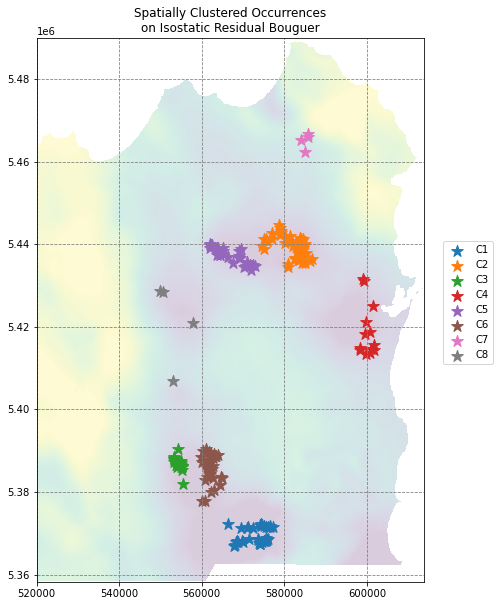

In [19]:
# import kmeans clustering module
from sklearn.cluster import KMeans

# run clustering on the coordinates of the occurences, 8 clusters is about right
occ_xypts = [[geom.x, geom.y] for geom in df.geometry]
kmeans_obj = KMeans(n_clusters=8, random_state=42).fit(occ_xypts)
df['cluster_labels'] = kmeans_obj.labels_ + 1

# visualise the clusters
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(data[0], extent=region, vmin=np.nanpercentile(data[0], 5), vmax=np.nanpercentile(data[0], 95), alpha=0.2)
for i in np.unique(df.cluster_labels):
  df[df.cluster_labels==i].plot(ax=ax, markersize=150, marker='*', label='C{}'.format(i))
ax.set(title='Spatially Clustered Occurrences\non Isostatic Residual Bouguer')
ax.legend(loc=(1.05,0.4))
plt.show()

/tmp/ipykernel_28321/2164095668.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, shrink=0.5, label='Cluste Label ID')


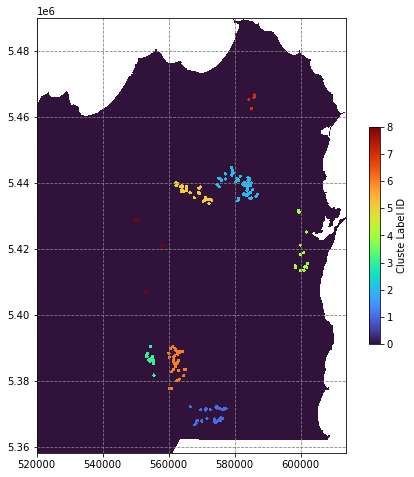

In [20]:
# rasterize the occurence points by cluster
clustermap = rasterize(shapes=((geom,c) for c, geom in zip(df.cluster_labels, df.buffer(500).geometry)), 
                       out_shape=data[0].shape, fill=0., transform=transf)

# apply the no data mask
clustermap[nodata_mask] = np.nan

# plot the predictions
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(clustermap, extent=region, interpolation='nearest', cmap='turbo')
fig.colorbar(im, shrink=0.5, label='Cluste Label ID')
plt.show()

In [21]:
# create a data selection function
def cluster_pixel_selection(clustermap, data_cube, class_1_list):
  X = data_cube.reshape((data_cube.shape[0], data_cube.shape[1] * data_cube.shape[2])).T
  y = clustermap.flatten() 
  X = X[~np.isnan(y)]
  y = y[~np.isnan(y)]
  y[np.isin(y, class_1_list)] = 1
  y[y!=1] = 0
  return X, y

# create a function to fit a model to input data
def fit_stratifiedrandomforest(X, y):
  X, y = rus.fit_resample(X, y)
  model = RandomForestClassifier(n_estimators=15, n_jobs=-1)
  return model.fit(X, y)

# define a function to determine performance on holdout occurence clusters
def holdout_roc_auc(clustermap, data_cube, holdout_cluster_list, model_cluster_list, model):
  X = data_cube.reshape((data_cube.shape[0], data_cube.shape[1] * data_cube.shape[2])).T
  y = clustermap.flatten() 
  X = X[~np.isnan(y)]
  y = y[~np.isnan(y)]
  X = X[~np.isin(y, model_cluster_list)]
  y = y[~np.isin(y, model_cluster_list)]
  y[np.isin(y, holdout_cluster_list)] = 1
  # predict onto X
  y_pred = model.predict_proba(X)
  fpr, tpr, threshold = roc_curve(y, y_pred[:,1])
  roc_auc = auc(fpr, tpr)
  return fpr, tpr, roc_auc

# define a function to generate probability maps from a model
def get_proba_map(nodata_mask, data_cube, model):
  X = data_cube.reshape((data_cube.shape[0], data_cube.shape[1] * data_cube.shape[2])).T
  X = X[~nodata_mask.flatten()]
  pred_ar = np.zeros_like(data_cube[0].flatten())
  pred_ar[~nodata_mask.flatten()] = model.predict_proba(X)[:,1]
  pred_ar[nodata_mask.flatten()] = np.nan
  pred_ar = pred_ar.reshape(data_cube[0].shape)
  return pred_ar

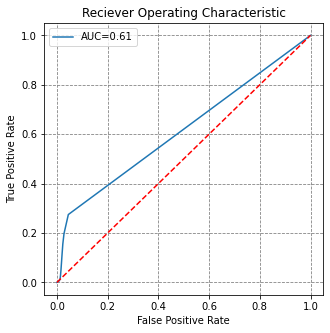

In [22]:
# train a model on cluster 1
X, y = cluster_pixel_selection(clustermap, data, [1])
model = fit_stratifiedrandomforest(X, y)
fpr, tpr, roc_auc = holdout_roc_auc(clustermap, data, [2,3,4,5,6,7,8], [1], model)

# visualise this
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label='AUC={}'.format(round(roc_auc,2)))
ax.plot([0,1], [0,1], 'r--')
ax.set(title='Reciever Operating Characteristic', 
       ylabel='True Positive Rate', xlabel='False Positive Rate')
ax.legend()
plt.show()

In [23]:
# import progress bar
from tqdm import tqdm

# loop through clusters
models, holdout_clusters = [], []
fprs, tprs, roc_aucs = [], [], []
for i in tqdm(range(1,9)):
  X, y = cluster_pixel_selection(clustermap, data, [j for j in range(1,9) if j!=i])
  model = fit_stratifiedrandomforest(X, y)
  fpr, tpr, roc_auc = holdout_roc_auc(clustermap, data, [i], [j for j in range(1,9) if j!=i], model)
  holdout_clusters.append(i)
  models.append(model)
  fprs.append(fpr)
  tprs.append(tpr)
  roc_aucs.append(roc_auc)

100%|██████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.57s/it]


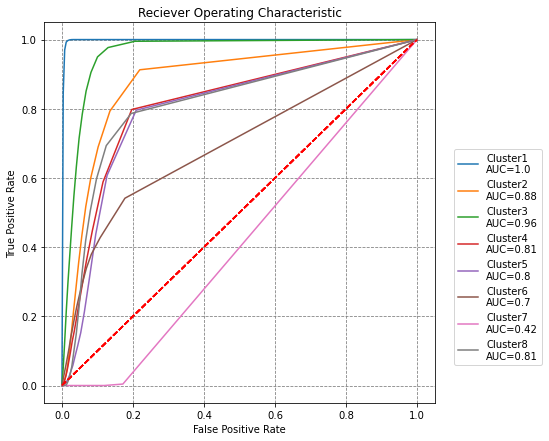

In [24]:
# plot ROC curves for each holdout model
fig, ax = plt.subplots(figsize=(7,7))
for fpr, tpr, roc_auc, hc in zip(fprs, tprs, roc_aucs, holdout_clusters):
  ax.plot(fpr, tpr, label='Cluster{}\nAUC={}'.format(hc, round(roc_auc,2)))
  ax.plot([0,1], [0,1], 'r--')
  ax.set(title='Reciever Operating Characteristic', 
         ylabel='True Positive Rate', xlabel='False Positive Rate')
  ax.legend(loc=(1.05,0.1))
plt.show()

In [25]:
# loop through models to generate pridction maps
prob_maps = []
for m in models:
  prob_maps.append(get_proba_map(nodata_mask, data, m))
prob_maps[0].shape

(2633, 1876)

/tmp/ipykernel_28321/2177181897.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')
/tmp/ipykernel_28321/2177181897.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')
/tmp/ipykernel_28321/2177181897.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')
/tmp/ipykernel_28321/2177181897.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated

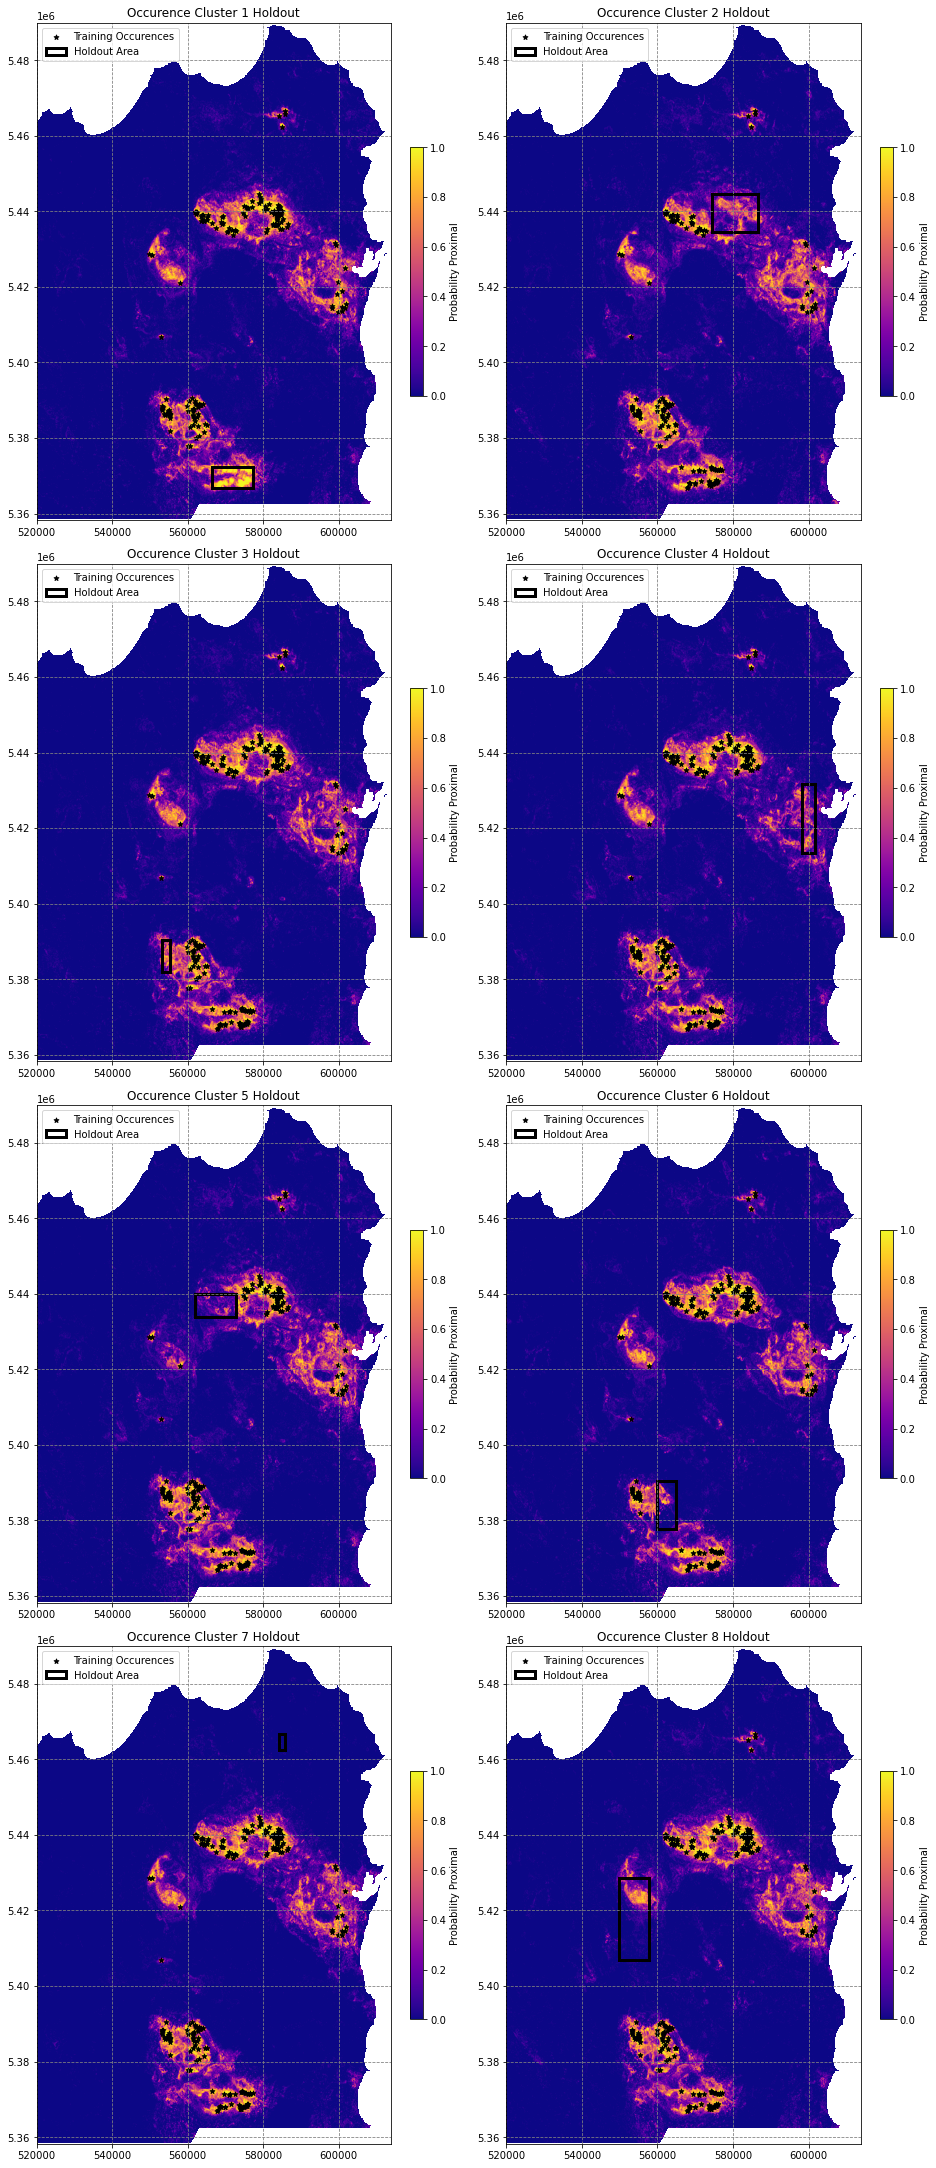

In [26]:
# import matplotlib Rectangle to highlight holdout area
from matplotlib.patches import Rectangle

# plot these probability maps
fig, axes = plt.subplots(4, 2, figsize=(13,30), constrained_layout=True)
for i, ax in enumerate(axes.flatten()):
  if i < len(holdout_clusters):
    # plot the image
    im = ax.imshow(prob_maps[i], vmin=0, vmax=1, cmap='plasma', extent=region)
    fig.colorbar(im, ax=ax, shrink=0.5, label='Probability Proximal')
    df[df.cluster_labels!=holdout_clusters[i]].plot(ax=ax, markersize=25, color='k', marker='*', label='Training Occurences')
    # get holdout bounds
    xmin, ymin, xmax, ymax = df[df.cluster_labels==holdout_clusters[i]].total_bounds
    xlen, ylen = abs(xmin-xmax), abs(ymin-ymax)
    # draw the rectangle
    ax.add_patch(Rectangle((xmin, ymin), xlen, ylen, linewidth=3, edgecolor='k', facecolor='none', label='Holdout Area'))
    ax.legend(loc='upper left')
    ax.set(title='Occurence Cluster {} Holdout'.format(i+1))
  else:
    ax.axis('off')
plt.show()

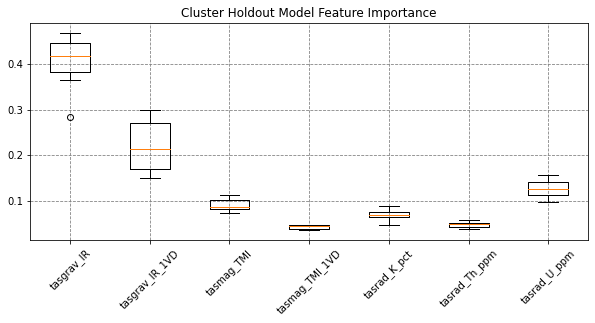

In [27]:
# feature importance
fig, ax = plt.subplots(figsize=(10,4))
feat_imps = np.array([m.feature_importances_ for m in models])
ax.boxplot(feat_imps, labels=names)
ax.set(title='Cluster Holdout Model Feature Importance')
plt.xticks(rotation=45)
plt.show()